In [3]:
import math
import random
import abc
from matplotlib import pyplot as plt
import json

### Activation function

In [4]:
class ActivationF(abc.ABC):

    @abc.abstractmethod
    def calc(self, x):
        pass

    @abc.abstractmethod
    def derive(self, x):
        pass

    @staticmethod
    def from_name(name="tanh"):
        if name == "tanh":
            return TanhF()
        if name == "softmax":
            return SoftmaxF()
        if name == "sigmoid":
            return SigmoidF()
        
class TanhF(ActivationF):

    def calc(self, x):
        return (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))

    def derive(self, x):
        return 1 - self.calc(x)**2
  
    
    
class SoftmaxF(ActivationF):

    def calc(self, some_data):
        #print(some_data)
        es_x = [math.exp(x) for x in some_data]
        return [e_x / sum(es_x) for e_x in es_x]

    def derive(self, x):
        pass
    
    
class SigmoidF(ActivationF):

    def calc(self, x):
        return 1 / (1 + math.exp(-x))


    def derive(self, x):
        return self.calc(x)*(1-self.calc(x))

### Neuron class

In [26]:
class Unit:
    def __init__(self, input_size, prev_layer: "Layer" = None, activation="tanh"):
        self.activation = ActivationF.from_name(activation)
        self.activation_name = activation
        self.weights = [random.uniform(-1, 1) for weight_n in range(input_size)]
        self.prev_layer = prev_layer
        # your code here
        self.features = None
        self.forward_result = 0
        self.delta = 0

    def forward(self):
        if self.prev_layer is not None:
            self.features = [unit.forward_result for unit in self.prev_layer.units]
        self.forward_result = self.activation.calc(self.weighted_sum(self.features))
        return self.forward_result

    def backward(self, error, learning_rate=0.01):
        # your code here
        self.delta = error * self.activation.derive(self.forward_result)
        new_w = []
        for i, w in enumerate(self.weights):
            w+=learning_rate* self.delta* self.features[i]
            new_w.append(w)
        self.weights  = new_w 
    
    def weighted_sum(self, inputs):
        return sum([weight * x for weight, x in zip(self.weights, inputs)])
 

### Layer class

In [20]:
class Layer:
    def __init__(self, input_size, size, activation="tanh", prev_layer = None):
        self.activation = ActivationF.from_name(activation)
        self.units = [Unit(input_size, prev_layer=prev_layer, activation=activation)
                      for unit_n in range(size)]
        self.prev_layer = prev_layer
        self.errors = []
        self.output = []
    
    def forward(self):
        self.output = [unit.forward() for unit in self.units]
        return self.output

    def backward(self, learning_rate):
        return [unit.backward(e, learning_rate) for unit, e in zip(self.units, self.errors)]
    
    def error_back(self, next_layer):
        for j in range(len(self.units)):
            error = 0.0
            for unit in next_layer.units:
                error += (unit.weights[j] * unit.delta)
            self.errors.append(error)

### perceptron class - alows different activation functions

In [39]:
class MLP:
    def __init__(self, input_size, output_size, sizes, activation= "tanh", learning_rate=0.01):
        
        self.activation = activation
        self.learning_rate=learning_rate
        layers_sizes = [input_size] + sizes + [output_size]
        if type(self.activation)==str:
            activation = [activation for i in range(len(layers_sizes)-1)]
        self.layers = []
        prev_added_layer = None
        for layer_in_size, layer_out_size, activation in zip(layers_sizes[:-1], layers_sizes[1:], activation):
            self.layers.append(Layer(layer_in_size, layer_out_size, activation, prev_layer=prev_added_layer))
            prev_added_layer = self.layers[-1]
        #self.layers.append(Layer(layers_sizes[-2], layers_sizes[-1], "softmax", prev_layer=prev_added_layer))
                  
    def train_single_entry(self, features, target_mhe):
        # region forward pass
        softmax = ActivationF.from_name('softmax')
        for unit in self.layers[0].units:
            unit.features = features

        for layer in self.layers:
            curr_layer_output = layer.forward()
        last_layer_output = curr_layer_output
        # endregion forward pass
        pred = softmax.calc(last_layer_output)
        loss = (- sum(class_target * math.log(class_pred) for class_target, class_pred in zip(target_mhe, pred)))/len(pred)
        # region backward pass
        errors = [class_pred - t for t, class_pred in zip(target_mhe, pred)]
        # your code here
        # endregion backward pass
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            errors = []
            if i != len(self.layers)-1:
                layer.error_back(self.layers[i+1])
                layer.backward(self.learning_rate)
            else:
                errors = [t - class_pred for t, class_pred in zip(target_mhe, pred)]
                for i, p, unit in zip(errors, pred, layer.units):
                    unit.delta = i/len(unit.weights)
                    new_w = []
                    for j, w in enumerate(unit.weights):
                        w+=0.01*unit.delta*unit.features[j]
                        new_w.append(w)
                    unit.weights  = new_w 
        return loss,last_layer_output

    def train(self, X, Y):
        losses = []
        preds = []
        for x,y in zip(X,Y):
            l, p = self.train_single_entry(x, y)
            losses.append(l)
            preds.append(p)
        return sum(losses)/len(X), preds
    # your code here
    
    def save_weights(self, filename):
        l = []
        for layer in self.layers:
            j = json.dumps([unit.weights for unit in layer.units])
            l.append(j)
        with open(filename, 'w') as outfile:
            json.dump(l, outfile)
        #return json.dumps(l)
    
    """def predict(self, row):
        for unit in self.layers[0].units:
            unit.features = row
        for layer in self.layers:
            curr_layer_output = layer.forward()
        pred = self.layers[-1].units[0].activation.calc(curr_layer_output)
        return  pred #.index(max(pred))"""
 

### For loading its needed to specift file and input size

In [9]:
def load_weights(filename, input_size):
    with open(filename) as json_file:
        w = json.load(json_file)
    #w =  json.loads(filename)
    model = MLP(input_size, len(json.loads(w[-1])), [len(json.loads(l)) for l in w[:-1]])
    for layer,l in zip(model.layers, w):
        l = json.loads(l)
        for q,unit in zip(l,layer.units):
            unit.weights = q
    return model

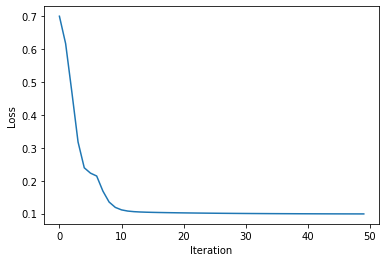

In [68]:
from mlxtend.data import iris_data
X, Y = iris_data()
Y = Y.reshape((150,1))

irisSet = MLP(4, 3, [12, 8])
losses = []
preds = []
for epoch in range(50):
    l, p = irisSet.train(X, Y)
    losses.append(l)
    preds.append(p)
    
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

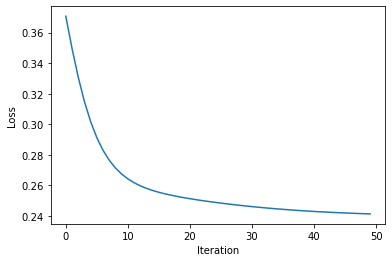

In [44]:
from mlxtend.data import iris_data
X, Y = iris_data()
Y = Y.reshape((150,1))

irisSet = MLP(4, 3, [12, 12], "sigmoid")
losses = []
preds = []
for epoch in range(50):
    l, p = irisSet.train(X, Y)
    losses.append(l)
    preds.append(p)
    
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

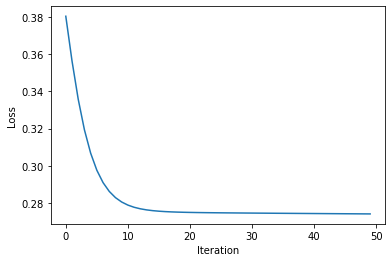

In [49]:
from mlxtend.data import iris_data
X, Y = iris_data()
Y = Y.reshape((150,1))

irisSet = MLP(4, 3, [12, 12], ["tanh", "sigmoid","sigmoid"], 0.001)
losses = []
preds = []
for epoch in range(50):
    l, p = irisSet.train(X, Y)
    losses.append(l)
    preds.append(p)
    
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [50]:
irisSet.save_weights('data1.json')

In [51]:
model_mlp = load_weights('data1.json', 4)

In [53]:
model_mlp.layers[0].units[0].weights

[0.06920373707831166,
 -0.4472460724099706,
 0.07869594849664079,
 -0.19478758983481442]

In [54]:
irisSet.layers[0].units[0].weights

[0.06920373707831166,
 -0.4472460724099706,
 0.07869594849664079,
 -0.19478758983481442]